<a href="https://colab.research.google.com/github/ariliawulan/Deteksi-Penyakit-Daun-Padi/blob/main/Deteksi_Penyakit_Daun_Padi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORT LIBRARY

In [1]:
# import library

# array dan operasi matematika
import numpy as np
import pandas as pd

# environment
import os

# plot gambar
import matplotlib.pyplot as plt

# klasifikasi
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Activation, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# split dataset
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split

# DOWNLOAD DATASET

In [2]:
# permission kaggle credential

! chmod 600 /content/kaggle.json

chmod: cannot access '/content/kaggle.json': No such file or directory


In [3]:
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d tedisetiady/leaf-rice-disease-indonesia

Dataset URL: https://www.kaggle.com/datasets/tedisetiady/leaf-rice-disease-indonesia
License(s): copyright-authors
 46% 10.0M/21.6M [00:00<00:00, 32.1MB/s]
100% 21.6M/21.6M [00:00<00:00, 61.1MB/s]


# EKSTRAK FILE

In [4]:
# ekstrak file zip

import zipfile
zip_file = zipfile.ZipFile('/content/leaf-rice-disease-indonesia.zip')
zip_file.extractall('/tmp/leaf-rice-disease-indonesia/')

# LOAD DATASET


In [5]:
Name=[]
for file in os.listdir('/tmp/leaf-rice-disease-indonesia/'):
  Name+=[file]
print(Name)
print(len(Name))

['blast', 'tungro', 'blight']
3


In [6]:
print('total blast image: ', len(os.listdir('/tmp/leaf-rice-disease-indonesia/blast/')))
print('total blight image: ', len(os.listdir('/tmp/leaf-rice-disease-indonesia/blight/')))
print('total tungro image: ', len(os.listdir('/tmp/leaf-rice-disease-indonesia/tungro/')))

total blast image:  80
total blight image:  80
total tungro image:  80


# PREPARATION DATA

In [7]:
# Inisialisasi daftar untuk menyimpan gambar dan label
images = []
labels = []
count = 0

# Fungsi untuk memuat dan memproses gambar menggunakan TensorFlow dan Keras
def load_and_preprocess_image(filepath, target_size=(256, 256), greyscale=False, color_mode='rgb'):
    # Membaca dan resize gambar
    image = load_img(filepath, target_size=target_size)
    image = img_to_array(image)

    # Normalisasi
    image = image / 255.0

    return image

In [8]:
# Loop melalui setiap folder dalam daftar Name
for name in Name:
    path = os.path.join('/tmp/leaf-rice-disease-indonesia/', name)
    for im in os.listdir(path):
        if im.endswith('.jpg'):  # Hanya memproses file gambar dengan ekstensi .jpg
            # Preprocessing gambar
            image = load_and_preprocess_image(os.path.join(path, im))
            images.append(image)
            labels.append(count)
    count += 1

In [9]:
# Konversi daftar gambar dan label menjadi array NumPy
images = np.array(images)
labels = np.array(labels)

# Membagi dataset menjadi data pelatihan dan data uji
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Sekarang, bagi data pelatihan menjadi data pelatihan dan validasi
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Periksa ukuran setiap set
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (153, 256, 256, 3), (153,)
Validation set: (39, 256, 256, 3), (39,)
Test set: (48, 256, 256, 3), (48,)


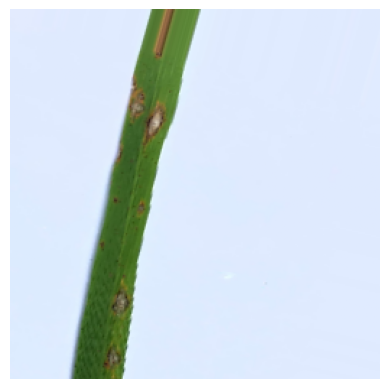

In [10]:
# Augmentasi data menggunakan ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

# Contoh augmentasi gambar pertama
sample_image = np.expand_dims(images[0], 0)  # Menambah dimensi batch
augmented_images = next(datagen.flow(sample_image, batch_size=1))

# Fungsi untuk menampilkan gambar
def display_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Menampilkan gambar hasil augmentasi
for augmented_image in augmented_images:
    display_image(augmented_image)
    break

# EKSTRAKSI FITUR


In [11]:
# Membangun arsitektur model
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(Name), activation='softmax')
])

# Mengompilasi model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Menampilkan ringkasan arsitektur model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

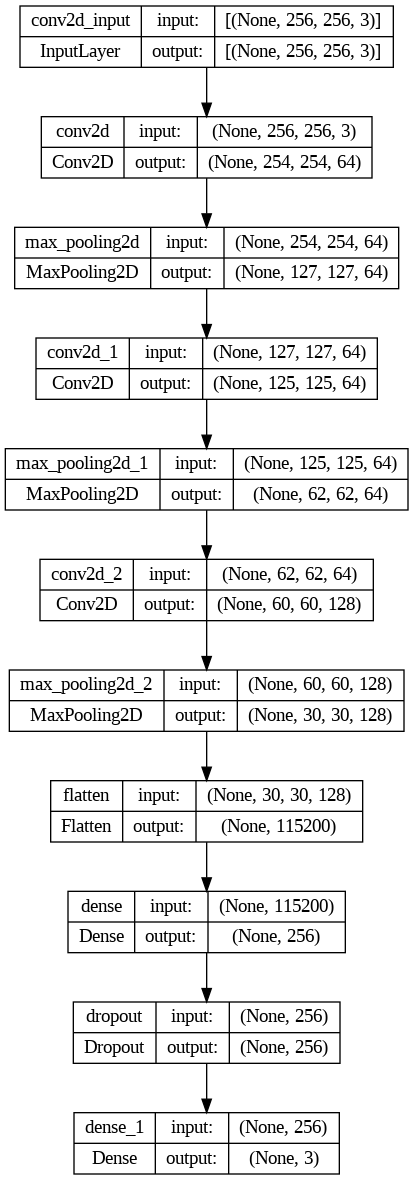

In [12]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# MELATIH MODEL

In [26]:
# Melatih model dengan data pelatihan dan validasi
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=64,
    validation_data=(X_val, y_val)
)

Epoch 1/150
3/3 [==============================] - 1s 305ms/step - loss: 0.0423 - accuracy: 1.0000 - val_loss: 0.2769 - val_accuracy: 0.8974
Epoch 2/150
3/3 [==============================] - 1s 272ms/step - loss: 0.0306 - accuracy: 1.0000 - val_loss: 0.2526 - val_accuracy: 0.9231
Epoch 3/150
3/3 [==============================] - 1s 197ms/step - loss: 0.0277 - accuracy: 0.9935 - val_loss: 0.2464 - val_accuracy: 0.9231
Epoch 4/150
3/3 [==============================] - 1s 189ms/step - loss: 0.0314 - accuracy: 1.0000 - val_loss: 0.2319 - val_accuracy: 0.9231
Epoch 5/150
3/3 [==============================] - 1s 197ms/step - loss: 0.0296 - accuracy: 1.0000 - val_loss: 0.2341 - val_accuracy: 0.8974
Epoch 6/150
3/3 [==============================] - 1s 239ms/step - loss: 0.0287 - accuracy: 1.0000 - val_loss: 0.2532 - val_accuracy: 0.9231
Epoch 7/150
3/3 [==============================] - 1s 241ms/step - loss: 0.0528 - accuracy: 0.9935 - val_loss: 0.2360 - val_accuracy: 0.9231
Epoch 8/150
3

# EVALUASI MODEL

In [27]:
# Mengevaluasi model pada data pengujian
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Memprediksi pada data pengujian
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Laporan klasifikasi
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_classes, target_names=Name))


2/2 [==============================] - 0s 26ms/step - loss: 0.0387 - accuracy: 0.9792
Test Loss: 0.038677964359521866
Test Accuracy: 0.9791666865348816
2/2 [==============================] - 0s 29ms/step
              precision    recall  f1-score   support

       blast       1.00      0.94      0.97        16
      tungro       0.94      1.00      0.97        15
      blight       1.00      1.00      1.00        17

    accuracy                           0.98        48
   macro avg       0.98      0.98      0.98        48
weighted avg       0.98      0.98      0.98        48



# VISUALISASI AKURASI

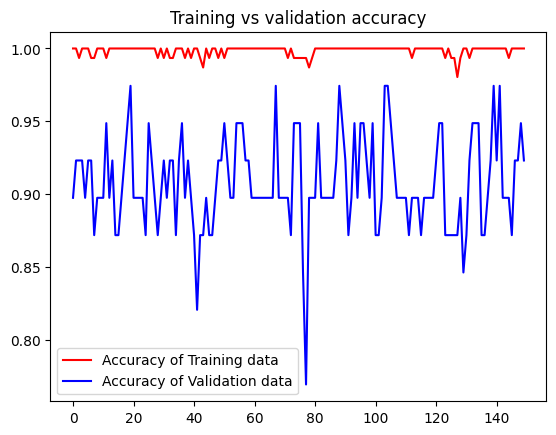

<Figure size 640x480 with 0 Axes>

In [42]:
get_acc = history.history['accuracy']
value_acc = history.history['val_accuracy']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()


# VISUALISASI LOS

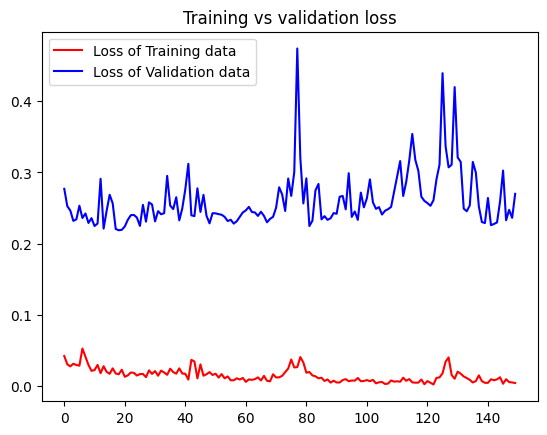

<Figure size 640x480 with 0 Axes>

In [43]:
get_loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()


# PREDIKSI BLIGHT

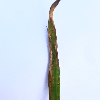

In [47]:
load_img("/tmp/leaf-rice-disease-indonesia/blight/IMG_0834.jpg",target_size=(100,100))

In [48]:
image=load_img("/tmp/leaf-rice-disease-indonesia/blight/IMG_0834.jpg",target_size=(100,100))

image=img_to_array(image)
image=image/255.0
prediction_image=np.array(image)
prediction_image= np.expand_dims(image, axis=0)

In [49]:
mapper = {0: 'blast', 1: 'tungro', 2: 'blight'}

prediction_image = load_and_preprocess_image("/tmp/leaf-rice-disease-indonesia/blight/IMG_0834.jpg", target_size=(256,256))
prediction_image = np.expand_dims(prediction_image, axis=0)

prediction = model.predict(prediction_image)
value = np.argmax(prediction)

move_name = mapper[value]

print(f"Predicted class: {move_name}")


1/1 [==============================] - 0s 25ms/step
Predicted class: blight


# PREDIKSI BLAST

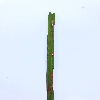

In [50]:
load_img("/tmp/leaf-rice-disease-indonesia/blast/IMG_0722.jpg",target_size=(100,100))

In [51]:
image=load_img("/tmp/leaf-rice-disease-indonesia/blast/IMG_0722.jpg",target_size=(100,100))
image=img_to_array(image)
image=image/255.0
prediction_image=np.array(image)
prediction_image= np.expand_dims(image, axis=0)

In [52]:
mapper = {0: 'blast', 1: 'tungro', 2: 'blight'}

prediction_image = load_and_preprocess_image("/tmp/leaf-rice-disease-indonesia/blast/IMG_0722.jpg", target_size=(256,256))
prediction_image = np.expand_dims(prediction_image, axis=0)

prediction = model.predict(prediction_image)
value = np.argmax(prediction)

move_name = mapper[value]

print(f"Predicted class: {move_name}")

1/1 [==============================] - 0s 18ms/step
Predicted class: blast


# PREDIKSI TUNGRO

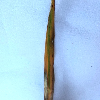

In [53]:
load_img("/tmp/leaf-rice-disease-indonesia/tungro/IMG_1028.jpg",target_size=(100,100))

In [54]:
image=load_img("/tmp/leaf-rice-disease-indonesia/tungro/IMG_1028.jpg",target_size=(100,100))
image=img_to_array(image)
image=image/255.0
prediction_image=np.array(image)
prediction_image= np.expand_dims(image, axis=0)

In [55]:
mapper = {0: 'blast', 1: 'tungro', 2: 'blight'}

prediction_image = load_and_preprocess_image("/tmp/leaf-rice-disease-indonesia/tungro/IMG_1028.jpg", target_size=(256,256))
prediction_image = np.expand_dims(prediction_image, axis=0)

prediction = model.predict(prediction_image)
value = np.argmax(prediction)

move_name = mapper[value]

print(f"Predicted class: {move_name}")

1/1 [==============================] - 0s 33ms/step
Predicted class: tungro
